### Determine cell types for metadata prompting

In [1]:
import os
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))


In [2]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

### Process validation datasets

In [5]:
validation_meta_df = pd.read_csv(os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cellxgene_validation_donors__third_draft.csv"))

In [6]:
# Stephen's validatdion table
# what we have called intestine is actually "small intestine"

tissue_ontology_term_id_to_coarse_name_map = dict()
for row in validation_meta_df['tissue_name_ont_coarsename_coarseont'].values:
    split_row = row.strip("()").split(', ')
    coarse_name = split_row[2].strip("'")
    if coarse_name == "intestine":
        coarse_name = "small intestine"
    tissue_ontology_term_id_to_coarse_name_map[split_row[1].strip("'")] = coarse_name


In [7]:
from tqdm.notebook import tqdm

obs_list = []

for val_idx in tqdm(range(1, 111)):
    
    val_adata_path = os.path.join(ROOT_PATH, "data", "cellariumgpt_validation", f"extract_{val_idx}.h5ad")
    val_adata = sc.read_h5ad(val_adata_path)

    obs_df = val_adata.obs.copy()
    obs_df['adata_path'] = val_adata_path
    obs_df['tissue_coarse'] = obs_df['tissue_ontology_term_id'].map(tissue_ontology_term_id_to_coarse_name_map)

    columns_to_keep = [
        "cell_type", "assay", "suspension_type", "disease", "sex", "tissue_coarse", "total_mrna_umis",
        "cell_type_distance_from_root", "dataset_id", "donor_id", "adata_path"]

    group_cols = ["cell_type", "donor_id"]

    obs_df = obs_df[columns_to_keep]

    agg_df_1 = obs_df.groupby(group_cols, as_index=False)["total_mrna_umis"].mean().rename(
        columns={"total_mrna_umis": "total_mrna_umis_avg"})
    agg_df_2 = obs_df.groupby(group_cols, as_index=False)["total_mrna_umis"].count().rename(
        columns={"total_mrna_umis": "n_cells"})

    obs_df = obs_df.drop_duplicates(subset=group_cols)
    obs_df = obs_df.drop(columns=["total_mrna_umis"])
    obs_df = obs_df.merge(agg_df_1, on=group_cols, how="left")
    obs_df = obs_df.merge(agg_df_2, on=group_cols, how="left")

    obs_list.append(obs_df)

  0%|          | 0/110 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModifi

In [8]:
df = pd.concat(obs_list, ignore_index=True).drop_duplicates()

In [190]:
included_assays = [
    "10x 3' v3", "10x 3' v2",
    "10x 5' v1", "10x 5' v2"]

df = df[df["assay"].isin(included_assays)]

In [191]:
df

,cell_type,assay,suspension_type,disease,sex,tissue_coarse,cell_type_distance_from_root,dataset_id,donor_id,total_mrna_umis_avg,n_cells
0,oligodendrocyte,10x 3' v3,nucleus,normal,male,brain,5.0,bab7432a-5cfe-45ea-928c-422d03c45cdd,#138,5040.933212,4956
1,cerebellar granule cell,10x 3' v3,nucleus,normal,male,brain,7.0,bab7432a-5cfe-45ea-928c-422d03c45cdd,#138,4264.749176,2731
2,interneuron,10x 3' v3,nucleus,normal,male,brain,4.0,bab7432a-5cfe-45ea-928c-422d03c45cdd,#138,9288.528169,142
3,unknown,10x 3' v3,nucleus,normal,male,brain,NaN,bab7432a-5cfe-45ea-928c-422d03c45cdd,#138,3819.324324,666
4,differentiation-committed oligodendrocyte prec...,10x 3' v3,nucleus,normal,male,brain,4.0,bab7432a-5cfe-45ea-928c-422d03c45cdd,#138,4756.629870,308
...,...,...,...,...,...,...,...,...,...,...,...
1896,microglial cell,10x 3' v3,cell,glioblastoma,male,brain,8.0,56c4912d-2bae-4b64-98f2-af8a84389208,ndGBM-06,4770.666667,18
1897,macrophage,10x 3' v3,cell,glioblastoma,male,brain,5.0,56c4912d-2bae-4b64-98f2-af8a84389208,ndGBM-06,10234.568627,51
1898,monocyte,10x 3' v3,cell,glioblastoma,male,brain,5.0,56c4912d-2bae-4b64-98f2-af8a84389208,ndGBM-06,7086.076923,13
1899,natural killer cell,10x 3' v3,cell,glioblastoma,male,brain,7.0,56c4912d-2bae-4b64-98f2-af8a84389208,ndGBM-06,5751.000000,1


In [192]:
# keep a reference to the original dataframe
validation_stats_df = df.copy()

In [193]:
coarse_tissues = df["tissue_coarse"].unique()
cell_type_strings = dict()

for coarse_tissue in coarse_tissues:
    tissue_df = df[df["tissue_coarse"] == coarse_tissue]

    agg_df = tissue_df.groupby(["cell_type", "suspension_type", "cell_type_distance_from_root"]).apply(
        lambda group: pd.Series({
            "assay_list": sorted(group["assay"].unique().tolist()),
            "total_mrna_umis_avg": group["total_mrna_umis_avg"].mean(),
            "donor_dataset_count": group[["donor_id", "dataset_id"]].drop_duplicates().shape[0],
            "disease_list": sorted(group["disease"].unique().tolist()),
            "sex_list": sorted(group["sex"].unique().tolist()),
            "tissue_list": sorted(group["tissue_coarse"].unique().tolist()),
            "n_cells": group["n_cells"].sum(),
        })
    ).dropna().reset_index()

    # Group by 'cell_type' and keep only the row with the highest 'n_cells'
    agg_df = agg_df.sort_values("n_cells", ascending=False)
    agg_df = agg_df.drop_duplicates(subset="cell_type").reset_index(drop=True)
    agg_df = agg_df[['cell_type', 'suspension_type', 'assay_list', 'total_mrna_umis_avg', 'n_cells']]

    print(coarse_tissue)
    display(agg_df.head(30))
    s = '[\n'
    for cell_type, n_cells in zip(agg_df["cell_type"].tolist(), agg_df["n_cells"].tolist()):
        s += "\t" + f'"{cell_type}", # {n_cells}' + "\n"
    s += ']'

    cell_type_strings[coarse_tissue] = s

brain


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,L2/3-6 intratelencephalic projecting glutamate...,nucleus,[10x 3' v3],32283.096081,40379.0
1,neuron,nucleus,[10x 3' v3],19390.023813,38825.0
2,oligodendrocyte,nucleus,"[10x 3' v2, 10x 3' v3]",3466.119566,34701.0
3,astrocyte,nucleus,[10x 3' v3],4337.817282,8561.0
4,pvalb GABAergic cortical interneuron,nucleus,[10x 3' v3],17218.924481,7344.0
5,vip GABAergic cortical interneuron,nucleus,[10x 3' v3],13455.119639,7249.0
6,glutamatergic neuron,nucleus,[10x 3' v2],6141.094851,7105.0
7,oligodendrocyte precursor cell,nucleus,"[10x 3' v2, 10x 3' v3]",6325.213182,6695.0
8,sst GABAergic cortical interneuron,nucleus,[10x 3' v3],14236.769992,6387.0
9,malignant cell,cell,"[10x 3' v2, 10x 3' v3]",12343.866509,5841.0


blood


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,classical monocyte,cell,"[10x 3' v2, 10x 5' v1]",3750.452919,15635.0
1,"CD4-positive, alpha-beta T cell",cell,"[10x 3' v2, 10x 5' v1, 10x 5' v2]",5918.412073,15511.0
2,natural killer cell,cell,"[10x 3' v2, 10x 5' v1, 10x 5' v2]",3041.429188,9283.0
3,"CD8-positive, alpha-beta T cell",cell,"[10x 3' v2, 10x 5' v1, 10x 5' v2]",4589.421460,9105.0
4,"naive thymus-derived CD4-positive, alpha-beta ...",cell,"[10x 3' v2, 10x 5' v1, 10x 5' v2]",4060.653027,7317.0
5,B cell,cell,"[10x 3' v2, 10x 5' v1, 10x 5' v2]",3876.332703,5547.0
6,"CD8-positive, alpha-beta cytotoxic T cell",cell,"[10x 5' v1, 10x 5' v2]",3894.209560,4782.0
7,"CD14-positive, CD16-negative classical monocyte",cell,[10x 5' v2],5123.484024,4632.0
8,T cell,cell,"[10x 3' v3, 10x 5' v2]",5692.380368,4489.0
9,mature B cell,cell,"[10x 3' v3, 10x 5' v2]",6323.356494,4084.0


small intestine


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,plasma cell,cell,[10x 3' v2],5553.572236,15499.0
1,mesenchymal cell,cell,[10x 3' v2],4525.519896,5780.0
2,T cell,cell,"[10x 3' v2, 10x 3' v3]",2111.129280,4706.0
3,macrophage,cell,"[10x 3' v2, 10x 3' v3]",3862.732963,4629.0
4,"CD4-positive, alpha-beta T cell",cell,[10x 3' v2],2028.931384,4371.0
5,"CD8-positive, alpha-beta T cell",cell,[10x 3' v2],1724.007334,3844.0
6,B cell,cell,"[10x 3' v2, 10x 3' v3]",4313.221224,2755.0
7,fibroblast,cell,"[10x 3' v2, 10x 3' v3]",9551.070341,1974.0
8,plasmacytoid dendritic cell,cell,[10x 3' v2],1077.892595,1788.0
9,intestinal epithelial cell,cell,"[10x 3' v2, 10x 3' v3]",14221.150038,1196.0


kidney


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,abnormal cell,cell,[10x 3' v2],12538.982838,2911.0
1,macrophage,cell,[10x 3' v2],8449.707044,2236.0
2,kidney collecting duct principal cell,cell,[10x 3' v3],8449.237204,1569.0
3,kidney loop of Henle thin descending limb epit...,cell,[10x 3' v3],3534.306313,1283.0
4,T cell,cell,"[10x 3' v2, 10x 3' v3]",4329.951364,1114.0
5,endothelial cell,cell,"[10x 3' v2, 10x 3' v3]",5883.656285,875.0
6,kidney loop of Henle thin ascending limb epith...,cell,[10x 3' v3],5464.683603,866.0
7,kidney loop of Henle thick ascending limb epit...,cell,[10x 3' v3],7850.607488,851.0
8,epithelial cell of proximal tubule,cell,[10x 3' v3],4531.826804,486.0
9,kidney collecting duct intercalated cell,cell,[10x 3' v3],9716.801338,226.0


liver


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,hepatic pit cell,cell,[10x 5' v2],4727.118963,2410.0
1,"CD8-positive, alpha-beta T cell",cell,[10x 5' v2],5183.405436,2290.0
2,Kupffer cell,cell,[10x 5' v2],9744.089530,2091.0
3,natural killer cell,cell,[10x 5' v2],5103.622728,2062.0
4,macrophage,cell,"[10x 3' v2, 10x 5' v2]",9768.034407,2021.0
5,"CD4-positive, alpha-beta T cell",cell,[10x 5' v2],5362.041940,1677.0
6,monocyte,cell,[10x 5' v2],9390.691564,1274.0
7,hepatocyte,cell,"[10x 3' v2, 10x 5' v2]",12846.595798,989.0
8,periportal region hepatocyte,cell,"[10x 3' v2, 10x 5' v2]",14351.769046,967.0
9,mature B cell,cell,[10x 5' v2],6559.016918,693.0


lung


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,alveolar macrophage,cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",10122.769629,8713.0
1,malignant cell,cell,"[10x 3' v2, 10x 3' v3]",7534.843272,7659.0
2,"CD8-positive, alpha-beta T cell",cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",2724.637339,7484.0
3,type II pneumocyte,cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",5798.839615,5653.0
4,"CD4-positive, alpha-beta T cell",cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",2750.362418,4960.0
5,macrophage,cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",5089.378173,4748.0
6,capillary endothelial cell,cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",2181.541895,3835.0
7,B cell,cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",2724.590943,3471.0
8,classical monocyte,cell,"[10x 3' v2, 10x 3' v3, 10x 5' v1]",3093.368587,2773.0
9,T cell,cell,"[10x 3' v2, 10x 5' v1]",7370.905991,2739.0


thymus


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,"CD8-alpha-alpha-positive, alpha-beta intraepit...",cell,[10x 5' v1],5111.774100,2670.0
1,"double-positive, alpha-beta thymocyte",cell,[10x 5' v1],5686.260267,2480.0
2,fibroblast,cell,[10x 5' v1],4200.292530,2317.0
3,regulatory T cell,cell,[10x 5' v1],5042.266733,655.0
4,"CD4-positive, alpha-beta T cell",cell,[10x 5' v1],3255.285000,600.0
5,double negative thymocyte,cell,[10x 5' v1],6386.249482,566.0
6,"CD8-positive, alpha-beta T cell",cell,[10x 5' v1],3775.479545,440.0
7,T cell,cell,[10x 5' v1],6310.054936,204.0
8,alpha-beta T cell,cell,[10x 5' v1],2652.188811,143.0
9,myofibroblast cell,cell,[10x 5' v1],5130.400000,65.0


heart


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,cardiac muscle myoblast,nucleus,[10x 3' v3],10005.930778,21050.0
1,fibroblast of cardiac tissue,nucleus,[10x 3' v3],2971.909108,13244.0
2,cardiac endothelial cell,nucleus,[10x 3' v3],2555.895108,8661.0
3,immature innate lymphoid cell,nucleus,[10x 3' v3],2228.929211,4504.0
4,pericyte,nucleus,[10x 3' v3],2306.912812,3264.0
5,mural cell,nucleus,[10x 3' v3],1798.207321,2303.0
6,endothelial cell,nucleus,[10x 3' v3],1662.228321,1742.0
7,myeloid cell,nucleus,[10x 3' v3],2147.811363,1658.0
8,cardiac muscle cell,nucleus,[10x 3' v3],6741.016132,1397.0
9,lymphoid lineage restricted progenitor cell,nucleus,[10x 3' v3],1742.586052,1287.0


nose


,cell_type,suspension_type,assay_list,total_mrna_umis_avg,n_cells
0,tracheal goblet cell,cell,[10x 5' v1],11535.702018,2020.0
1,basal cell of epithelium of trachea,cell,[10x 5' v1],8211.102237,1159.0
2,secretory cell,cell,[10x 5' v1],8674.336407,1065.0
3,ciliated cell,cell,[10x 5' v1],6560.115789,646.0
4,"CD8-positive, alpha-beta memory T cell",cell,[10x 5' v1],1933.067823,338.0
5,memory B cell,cell,[10x 5' v1],3113.299020,204.0
6,dendritic cell,cell,[10x 5' v1],9231.552545,163.0
7,multi-ciliated epithelial cell,cell,[10x 5' v1],10402.805195,78.0
8,Langerhans cell,cell,[10x 5' v1],4117.785714,50.0
9,monocyte,cell,[10x 5' v1],2883.625000,49.0


In [194]:
cell_type_strings.keys()

dict_keys(['brain', 'blood', 'small intestine', 'kidney', 'liver', 'lung', 'thymus', 'heart', 'nose'])

#### Brain

In [195]:
print(cell_type_strings['brain'])

[
	"L2/3-6 intratelencephalic projecting glutamatergic neuron", # 40379.0
	"neuron", # 38825.0
	"oligodendrocyte", # 34701.0
	"astrocyte", # 8561.0
	"pvalb GABAergic cortical interneuron", # 7344.0
	"vip GABAergic cortical interneuron", # 7249.0
	"glutamatergic neuron", # 7105.0
	"oligodendrocyte precursor cell", # 6695.0
	"sst GABAergic cortical interneuron", # 6387.0
	"malignant cell", # 5841.0
	"microglial cell", # 5683.0
	"lamp5 GABAergic cortical interneuron", # 5123.0
	"astrocyte of the cerebral cortex", # 4539.0
	"neural cell", # 3740.0
	"GABAergic neuron", # 3494.0
	"mature astrocyte", # 3439.0
	"macrophage", # 3309.0
	"cerebellar granule cell", # 2731.0
	"mature microglial cell", # 2453.0
	"corticothalamic-projecting glutamatergic cortical neuron", # 2273.0
	"L6b glutamatergic cortical neuron", # 2037.0
	"sncg GABAergic cortical interneuron", # 1984.0
	"endothelial cell", # 1739.0
	"choroid plexus epithelial cell", # 1688.0
	"near-projecting glutamatergic cortical neuron", # 1

In [196]:
brain_cell_types = [
	"GABAergic neuron", 
	"glutamatergic neuron", 
	"astrocyte", 
	"oligodendrocyte", 
	"oligodendrocyte precursor cell", 
	"microglial cell", 
	"cerebellar granule cell", 
	"endothelial cell",
]

#### Blood

In [197]:
print(cell_type_strings['blood'])

[
	"classical monocyte", # 15635.0
	"CD4-positive, alpha-beta T cell", # 15511.0
	"natural killer cell", # 9283.0
	"CD8-positive, alpha-beta T cell", # 9105.0
	"naive thymus-derived CD4-positive, alpha-beta T cell", # 7317.0
	"B cell", # 5547.0
	"CD8-positive, alpha-beta cytotoxic T cell", # 4782.0
	"CD14-positive, CD16-negative classical monocyte", # 4632.0
	"T cell", # 4489.0
	"mature B cell", # 4084.0
	"type I NK T cell", # 3963.0
	"central memory CD4-positive, alpha-beta T cell", # 3963.0
	"naive thymus-derived CD8-positive, alpha-beta T cell", # 3604.0
	"CD14-positive monocyte", # 3356.0
	"non-classical monocyte", # 3004.0
	"blood cell", # 2720.0
	"early pro-B cell", # 2572.0
	"effector memory CD8-positive, alpha-beta T cell", # 2528.0
	"CD16-positive, CD56-dim natural killer cell, human", # 2512.0
	"naive B cell", # 2237.0
	"regulatory T cell", # 2007.0
	"memory B cell", # 1950.0
	"gamma-delta T cell", # 1690.0
	"CD8-positive, alpha-beta memory T cell", # 1672.0
	"activated CD4-p

In [238]:
blood_cell_types = [
	"classical monocyte", # 15635.0
	"non-classical monocyte", # 3004.0
	"natural killer cell", # 9283.0
	"CD4-positive, alpha-beta T cell", # 15511.0
	"CD8-positive, alpha-beta T cell", # 9105.0
	"CD8-positive, alpha-beta cytotoxic T cell", # 4782.0
	"CD8-positive, alpha-beta memory T cell",
	"naive thymus-derived CD4-positive, alpha-beta T cell", # 7317.0
	"naive thymus-derived CD8-positive, alpha-beta T cell", # 3604.0
	"naive B cell", # 2237.0
    "memory B cell", # 1950.0
	"regulatory T cell", # 2007.0
	"gamma-delta T cell", # 1690.0
	"conventional dendritic cell", # 1483.0
]

#### Intestine

In [239]:
print(cell_type_strings['small intestine'])

[
	"plasma cell", # 15499.0
	"mesenchymal cell", # 5780.0
	"T cell", # 4706.0
	"macrophage", # 4629.0
	"CD4-positive, alpha-beta T cell", # 4371.0
	"CD8-positive, alpha-beta T cell", # 3844.0
	"B cell", # 2755.0
	"fibroblast", # 1974.0
	"plasmacytoid dendritic cell", # 1788.0
	"intestinal epithelial cell", # 1196.0
	"myeloid leukocyte", # 1112.0
	"mast cell", # 1016.0
	"regulatory T cell", # 876.0
	"enterocyte", # 785.0
	"mature NK T cell", # 669.0
	"naive T cell", # 397.0
	"monocyte", # 392.0
	"conventional dendritic cell", # 375.0
	"natural killer cell", # 351.0
	"dendritic cell", # 347.0
	"endothelial cell", # 275.0
	"endothelial cell of lymphatic vessel", # 255.0
	"blood vessel endothelial cell", # 194.0
	"IgG plasma cell", # 187.0
	"enteroendocrine cell", # 176.0
	"intraepithelial lymphocyte", # 151.0
	"pericyte", # 147.0
	"glial cell", # 141.0
	"myofibroblast cell", # 121.0
	"peripheral nervous system neuron", # 96.0
	"innate lymphoid cell", # 95.0
	"memory B cell", # 79.0
	"inte

In [240]:
intestine_cell_types = [
	"enterocyte", # 785.0
	"endothelial cell", # 275.0
	"enteroendocrine cell", # 176.0
	"pericyte", # 147.0
	"intestine goblet cell", # 69.0
]

#### Kidney

In [241]:
print(cell_type_strings['kidney'])

[
	"abnormal cell", # 2911.0
	"macrophage", # 2236.0
	"kidney collecting duct principal cell", # 1569.0
	"kidney loop of Henle thin descending limb epithelial cell", # 1283.0
	"T cell", # 1114.0
	"endothelial cell", # 875.0
	"kidney loop of Henle thin ascending limb epithelial cell", # 866.0
	"kidney loop of Henle thick ascending limb epithelial cell", # 851.0
	"epithelial cell of proximal tubule", # 486.0
	"kidney collecting duct intercalated cell", # 226.0
	"renal interstitial pericyte", # 221.0
	"vascular associated smooth muscle cell", # 130.0
	"kidney connecting tubule epithelial cell", # 114.0
	"B cell", # 95.0
	"kidney distal convoluted tubule epithelial cell", # 78.0
	"conventional dendritic cell", # 55.0
	"monocyte", # 43.0
	"mature NK T cell", # 41.0
	"natural killer cell", # 39.0
	"alternatively activated macrophage", # 38.0
	"cytotoxic T cell", # 35.0
	"plasma cell", # 34.0
	"mast cell", # 29.0
	"kidney interstitial fibroblast", # 23.0
	"podocyte", # 16.0
	"parietal epithel

In [242]:
kidney_cell_types = [
	"kidney collecting duct principal cell", # 1569.0
	"kidney loop of Henle thin descending limb epithelial cell", # 1283.0
	"kidney loop of Henle thin ascending limb epithelial cell", # 866.0
	"kidney loop of Henle thick ascending limb epithelial cell", # 851.0
	"epithelial cell of proximal tubule", # 486.0
	"kidney collecting duct intercalated cell", # 226.0
	"renal interstitial pericyte", # 221.0
]

#### Liver

In [243]:
print(cell_type_strings['liver'])

[
	"hepatic pit cell", # 2410.0
	"CD8-positive, alpha-beta T cell", # 2290.0
	"Kupffer cell", # 2091.0
	"natural killer cell", # 2062.0
	"macrophage", # 2021.0
	"CD4-positive, alpha-beta T cell", # 1677.0
	"monocyte", # 1274.0
	"hepatocyte", # 989.0
	"periportal region hepatocyte", # 967.0
	"mature B cell", # 693.0
	"T cell", # 634.0
	"centrilobular region hepatocyte", # 561.0
	"endothelial cell of pericentral hepatic sinusoid", # 387.0
	"endothelial cell of artery", # 375.0
	"plasma cell", # 360.0
	"alpha-beta T cell", # 316.0
	"fibroblast", # 294.0
	"intrahepatic cholangiocyte", # 275.0
	"endothelial cell of hepatic sinusoid", # 259.0
	"inflammatory macrophage", # 246.0
	"endothelial cell of periportal hepatic sinusoid", # 244.0
	"gamma-delta T cell", # 241.0
	"vein endothelial cell", # 237.0
	"hepatic stellate cell", # 218.0
	"conventional dendritic cell", # 198.0
	"neutrophil", # 189.0
	"innate lymphoid cell", # 98.0
	"erythrocyte", # 81.0
	"midzonal region hepatocyte", # 81.0
	"ma

In [244]:
liver_cell_types = [
	"hepatic pit cell", # 2410.0
	"Kupffer cell", # 2091.0
	"hepatocyte", # 989.0
	"periportal region hepatocyte", # 967.0
	"centrilobular region hepatocyte", # 561.0
	"endothelial cell of pericentral hepatic sinusoid", # 387.0
	"endothelial cell of artery", # 375.0
	"fibroblast", # 294.0
	"intrahepatic cholangiocyte", # 275.0
	"endothelial cell of hepatic sinusoid", # 259.0
	"hepatic stellate cell", # 218.0
]

#### Lung

In [245]:
print(cell_type_strings['lung'])

[
	"alveolar macrophage", # 8713.0
	"malignant cell", # 7659.0
	"CD8-positive, alpha-beta T cell", # 7484.0
	"type II pneumocyte", # 5653.0
	"CD4-positive, alpha-beta T cell", # 4960.0
	"macrophage", # 4748.0
	"capillary endothelial cell", # 3835.0
	"B cell", # 3471.0
	"classical monocyte", # 2773.0
	"T cell", # 2739.0
	"ciliated columnar cell of tracheobronchial tree", # 2600.0
	"plasma cell", # 2245.0
	"natural killer cell", # 2240.0
	"regulatory T cell", # 1990.0
	"vein endothelial cell", # 1312.0
	"CD1c-positive myeloid dendritic cell", # 1282.0
	"elicited macrophage", # 1262.0
	"type I pneumocyte", # 1089.0
	"endothelial cell of lymphatic vessel", # 992.0
	"monocyte", # 955.0
	"non-classical monocyte", # 854.0
	"myeloid cell", # 850.0
	"epithelial cell of lower respiratory tract", # 633.0
	"plasmacytoid dendritic cell", # 599.0
	"pulmonary interstitial fibroblast", # 504.0
	"club cell", # 473.0
	"pulmonary artery endothelial cell", # 443.0
	"mast cell", # 423.0
	"epithelial cell o

In [246]:
lung_cell_types = [
	"alveolar macrophage", # 8713.0
	"type II pneumocyte", # 5653.0
	"capillary endothelial cell", # 3835.0
	"ciliated columnar cell of tracheobronchial tree", # 2600.0
	"type I pneumocyte", # 1089.0
	"epithelial cell of lower respiratory tract", # 633.0
	"pulmonary interstitial fibroblast", # 504.0
	"club cell", # 473.0
	"pulmonary artery endothelial cell", # 443.0
	"epithelial cell of lung", # 376.0
	"fibroblast of lung", # 372.0
]

#### Heart

In [247]:
print(cell_type_strings['heart'])

[
	"cardiac muscle myoblast", # 21050.0
	"fibroblast of cardiac tissue", # 13244.0
	"cardiac endothelial cell", # 8661.0
	"immature innate lymphoid cell", # 4504.0
	"pericyte", # 3264.0
	"mural cell", # 2303.0
	"endothelial cell", # 1742.0
	"myeloid cell", # 1658.0
	"cardiac muscle cell", # 1397.0
	"lymphoid lineage restricted progenitor cell", # 1287.0
	"smooth muscle myoblast", # 846.0
	"neuronal receptor cell", # 665.0
	"lymphocyte", # 252.0
	"mast cell", # 224.0
	"adipocyte of epicardial fat of left ventricle", # 201.0
	"cardiac neuron", # 115.0
	"adipocyte", # 2.0
]


In [248]:
heart_cell_types = [
	"cardiac muscle myoblast", # 21050.0
	"fibroblast of cardiac tissue", # 13244.0
	"cardiac endothelial cell", # 8661.0
	"cardiac muscle cell", # 1397.0
	"cardiac neuron", # 115.0
]

In [249]:
all_cell_types = brain_cell_types + blood_cell_types + intestine_cell_types + kidney_cell_types + liver_cell_types + lung_cell_types + heart_cell_types

In [250]:
len(all_cell_types)

61

### Finalize the cell type list

In [251]:
df_list = []

for tissue, cell_types in zip(
    ['brain', 'blood', 'small intestine', 'kidney', 'liver', 'lung', 'heart'],
    [brain_cell_types, blood_cell_types, intestine_cell_types, kidney_cell_types, liver_cell_types, lung_cell_types, heart_cell_types]):
    df = pd.DataFrame(
        {'cell_type': cell_types,
         'tissue': tissue,
         'assay': 'TBD',
         'suspension_type': 'TBD',
         'sex': 'male',
         'disease': 'normal',
         'total_mrna_umis': 0.,
        })
    df_list.append(df)

cell_types_df = pd.concat(df_list, ignore_index=True)

In [252]:
# (deprecated)
# updated_rows = []

# for i_row, row in enumerate(cell_types_df.itertuples()):
#     _df = validation_stats_df[(validation_stats_df["cell_type"] == row.cell_type) & (validation_stats_df["tissue_coarse"] == row.tissue)]
#     _df = _df.groupby(["assay", "suspension_type", "sex"], as_index=False).apply(
#         lambda group: pd.Series(
#             {
#                 'n_cells': group["n_cells"].sum(),
#                 "total_mrna_umis_avg": sum([a * b for a, b in zip(group["total_mrna_umis_avg"].tolist(), group["n_cells"].tolist())]) / group["n_cells"].sum(),
#             }
#         )
#     ).dropna().sort_values("n_cells", ascending=False)
    
#     if not _df.empty:
#         updated_row = row._asdict()
#         updated_row['assay'] = _df.iloc[0]["assay"]
#         updated_row['suspension_type'] = _df.iloc[0]["suspension_type"]
#         updated_row['sex'] = _df.iloc[0]["sex"]
#         updated_row['total_mrna_umis'] = _df.iloc[0]["total_mrna_umis_avg"]
#         updated_row.pop('Index')
#         updated_rows.append(updated_row)
#     else:
#         updated_rows.append(row._asdict())

# cell_types_df = pd.DataFrame(updated_rows)


In [253]:
# let us use to census to identify the most abundant assay and suspension type for each tissue

import cellxgene_census

census = cellxgene_census.open_soma(census_version="2024-05-20")

In [254]:
default_disease = "normal"
default_sex = "male"

updated_rows = []

for tissue in ['brain', 'blood', 'small intestine', 'kidney', 'liver', 'lung', 'heart']:
    print(tissue)
    
    obs = cellxgene_census.get_obs(
        census, "homo_sapiens",
        value_filter=(
            f"""is_primary_data == True and tissue_general == "{tissue}" and disease == "{default_disease}" """
            f"""and sex == "{default_sex}" """
        )
    )

    obs = obs[obs["assay"].isin(included_assays)]
    top = obs.groupby(["assay", "suspension_type"]).size().sort_values(ascending=False)
    top_assay, top_suspension_type = top.index[0]
    
    tissue_df = cell_types_df[cell_types_df["tissue"] == tissue]
    top_obs = obs[(obs["assay"] == top_assay) & (obs["suspension_type"] == top_suspension_type)]

    for i_row, row in enumerate(tissue_df.itertuples()):
        cell_type = row.cell_type
        total_mrna_umis = top_obs[top_obs["cell_type"] == cell_type]["raw_sum"].mean()

        updated_row = dict()
        updated_row['cell_type'] = cell_type
        updated_row['assay'] = top_assay
        updated_row['suspension_type'] = top_suspension_type
        updated_row['tissue'] = tissue
        updated_row['sex'] = default_sex
        updated_row['disease'] = default_disease
        updated_row['total_mrna_umis'] = total_mrna_umis
        updated_rows.append(updated_row)


brain
blood
small intestine
kidney
liver
lung
heart


In [255]:
final_cell_types_df = pd.DataFrame(updated_rows)

In [256]:
# show the full table
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(final_cell_types_df)

,cell_type,assay,suspension_type,tissue,sex,disease,total_mrna_umis
0,GABAergic neuron,10x 3' v3,nucleus,brain,male,normal,5527.708887
1,glutamatergic neuron,10x 3' v3,nucleus,brain,male,normal,10683.399862
2,astrocyte,10x 3' v3,nucleus,brain,male,normal,5380.963698
3,oligodendrocyte,10x 3' v3,nucleus,brain,male,normal,5083.603161
4,oligodendrocyte precursor cell,10x 3' v3,nucleus,brain,male,normal,6609.696174
5,microglial cell,10x 3' v3,nucleus,brain,male,normal,3645.962305
6,cerebellar granule cell,10x 3' v3,nucleus,brain,male,normal,3935.779702
7,endothelial cell,10x 3' v3,nucleus,brain,male,normal,3115.828938
8,classical monocyte,10x 5' v2,cell,blood,male,normal,3922.025000
9,non-classical monocyte,10x 5' v2,cell,blood,male,normal,8436.318182


In [257]:
final_cell_types_df.to_csv(os.path.join(ROOT_PATH, "data", "cellariumgpt_validation", "cell_types_draft_1.csv"), index=False)

In [260]:
# TODO: add "prior" cells

#### Determine highly expressed genes

In [286]:
from tqdm.notebook import tqdm

# randomly sample 5_000 cells from each row of the final_cell_types_df and use that to identify highly expressed genes
max_cells = 10_000

tpm_ng = np.zeros((len(final_cell_types_df), 60530))
feature_id = None
feature_name = None

for n, row in tqdm(enumerate(final_cell_types_df.itertuples())):

    obs = cellxgene_census.get_obs(
        census, "homo_sapiens",
        value_filter=(
            f"""is_primary_data == True and tissue_general == "{row.tissue}" and disease == "{row.disease}" """
            f"""and sex == "{row.sex}" and cell_type == "{row.cell_type}" and assay == "{row.assay}" """
            f"""and suspension_type == "{row.suspension_type}" """
        )
    )

    if len(obs) > max_cells:
        soma_joinids = obs["soma_joinid"].sample(max_cells, random_state=1).tolist()
    else:
        soma_joinids = obs["soma_joinid"].tolist()
    
    adata = cellxgene_census.get_anndata(
        census,
        organism="Homo sapiens",
        obs_coords=soma_joinids,
    )

    if feature_id is None:
        feature_id = adata.var['feature_id'].values
    else:
        assert np.all(feature_id == adata.var['feature_id'].values)

    if feature_name is None:
        feature_name = adata.var['feature_name'].values
    else:
        assert np.all(feature_name == adata.var['feature_name'].values)

    tpm_g = np.asarray(adata.X.sum(0)).flatten()
    tpm_g = 1e6 * tpm_g / tpm_g.sum()

    tpm_ng[n, :] = tpm_g

0it [00:00, ?it/s]

In [287]:
# generate an anndata object

final_adata = sc.AnnData(
    X=tpm_ng,
    obs=final_cell_types_df,
    var=pd.DataFrame(
        {
            'feature_id': feature_id,
            'feature_name': feature_name,
        }
    )
)

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
final_adata.write_h5ad(os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cell_types_for_validation.h5ad"))

In [325]:
# finally, filter
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
model_var_names = sc.read_h5ad(REF_ADATA_PATH).var.index.values.tolist()

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [338]:
tpm_threshold = 1.

_final_adata = final_adata[:, final_adata.var['feature_id'].isin(model_var_names)]
X_ng = _final_adata.X

# renormalize to TPM
X_ng = 1e6 * X_ng / X_ng.sum(1, keepdims=True)

# expression mask
mask_g = (X_ng > tpm_threshold).sum(0) > 0

# filter
_final_adata = _final_adata[:, mask_g].copy()
_final_adata.X = 1e6 * _final_adata.X / _final_adata.X.sum(1, keepdims=True)
_final_adata.var = _final_adata.var.reset_index(drop=True)

_final_adata.write_h5ad(os.path.join(ROOT_PATH, "data", "cellariumgpt_artifacts", "cell_types_for_validation_filtered.h5ad"))

### Scratch space

In [14]:
adata = sc.read_h5ad(df[df['cell_type'] == 'enterocyte'].iloc[0].adata_path)

/opt/conda/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
import typing as t


def load_gene_info_table(gene_info_tsv_path: str, included_gene_ids: list[str]) -> t.Tuple[pd.DataFrame, dict, dict]:
    gene_info_df = pd.read_csv(gene_info_tsv_path, sep="\t")

    gene_symbol_to_gene_id_map = dict()
    for gene_symbol, gene_id in zip(gene_info_df['Gene Symbol'], gene_info_df['ENSEMBL Gene ID']):
        if gene_symbol != float('nan'):
            gene_symbol_to_gene_id_map[gene_symbol] = gene_id

    gene_id_to_gene_symbol_map = {
        gene_id: gene_symbol for gene_symbol, gene_id in gene_symbol_to_gene_id_map.items()}
    for gene_id in included_gene_ids:
        if gene_id not in gene_id_to_gene_symbol_map:
            gene_id_to_gene_symbol_map[gene_id] = gene_id

    return gene_info_df, gene_symbol_to_gene_id_map, gene_id_to_gene_symbol_map

gene_info_df, gene_symbol_to_gene_id_map, gene_id_to_gene_symbol_map = load_gene_info_table(GENE_INFO_PATH, adata.var.index.values.tolist())

In [22]:
adata.var['feature_name'] = list(map(gene_id_to_gene_symbol_map.get, adata.var.index.values.tolist()))

In [23]:
adata.var

,feature_name
ENSG00000187642,PERM1
ENSG00000078808,SDF4
ENSG00000272106,ENSG00000272106
ENSG00000162585,FAAP20
ENSG00000272088,ENSG00000272088
...,...
ENSG00000224281,SLC25A5-AS1
ENSG00000122121,XPNPEP2
ENSG00000228836,CT45A5
ENSG00000231937,ENSG00000231937


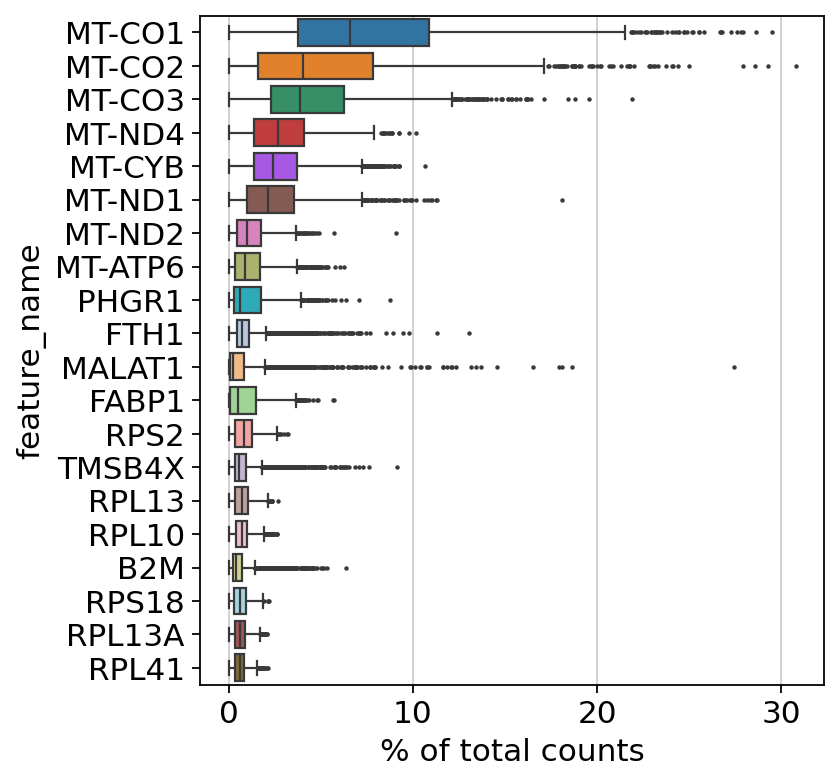

In [24]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='feature_name')